# 02 - Desafio Nuveo

## Este kernel abordará uma dentre as várias soluções de aprendizado profundo para identificar e classificar:
### Se uma assinatura é pertencente ao autor A 
### Se é uma tentativa do autor A de driblar sua assinatura
### Se é uma tentativa de fraude de um autor B para o autor A

## Exploração dos Dados

In [1]:
import warnings
warnings.filterwarnings("ignore") # Ignorando alguns warnings afim de manter o kernel mais legível

#Importando bibliotecas

#Nesta primeira parte utilizaremos como principais bibliotecas de exploração de dados o Pandas e o Seaborn
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

In [2]:
# Nesta celula definimos o local onde se encontra o dataset a ser analisado
data_dir = 'TrainingSet'

df = CreateDataFrame(data_dir)

In [3]:
# Observandos se os dados foram corretamente alocados no DataFrame
df.head()

,path,classification,files
0,TrainingSet\Disguise\D023.png,Disguise,D023.png
1,TrainingSet\Disguise\D035.png,Disguise,D035.png
2,TrainingSet\Disguise\D037.png,Disguise,D037.png
3,TrainingSet\Disguise\D044.png,Disguise,D044.png
4,TrainingSet\Disguise\D045.png,Disguise,D045.png


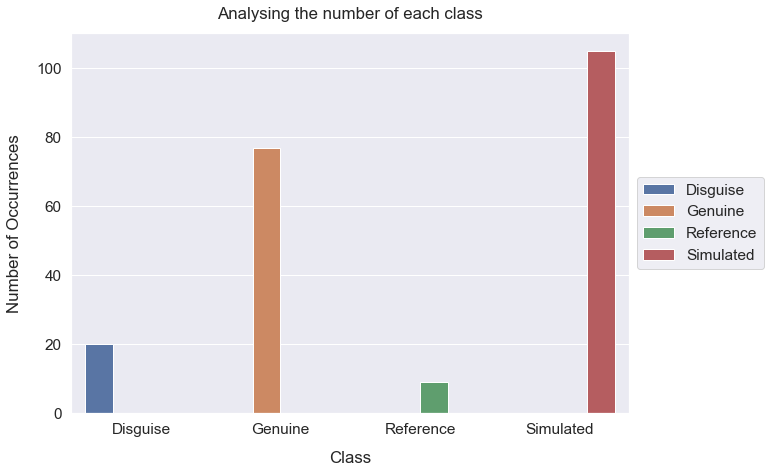

In [4]:
# Visualizando a distribuição dos dados no dataset por categoria
PlotCategorical(dataframe=df, 
                x="classification", 
                title="Analysing the number of each class",
                x_label="Class",
                y_label="Number of Occurrences")

In [5]:
# De início, utilizaremos as informações de maior relevancia
# Ou seja, verificaremos se uma assinatura é do Autor A ou se é uma Falsificação
train_df = df[(df.classification != 'Reference') & (df.classification != 'Disguise')]

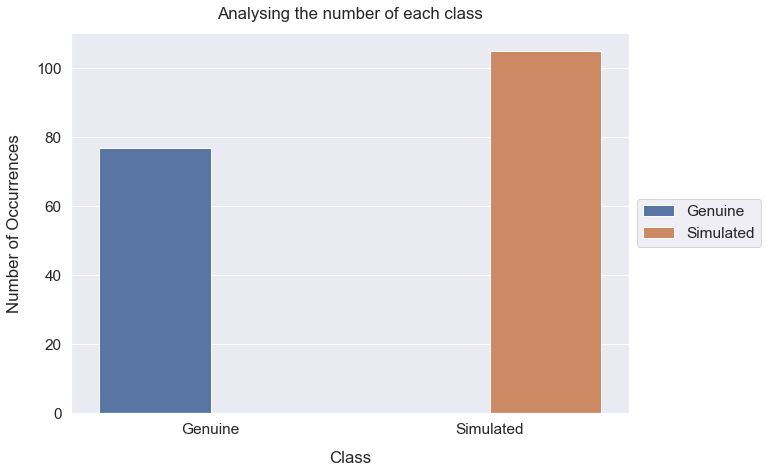

In [6]:
# Visualizando a distribuição entre as assinaturas do Autor A e as Falsificações de assinatura
PlotCategorical(dataframe=train_df, 
                x="classification", 
                title="Analysing the number of each class",
                x_label="Class",
                y_label="Number of Occurrences")

## Criando o modelo para classificação genuine ou simulated

In [7]:
# Nesta seção, utilizaremos duas bibliotecas

# O Keras é uma biblioteca de Alto Nivel que trabalha em cima de vários frameworks de aprendizagem profunda
# Aqui será o Tensorflow o seu backend
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.optimizers import *

# O Scikit-Learn é uma biblioteca de ciencia de dados extremamente versátil
# Neste kernel, será utilizado o train_test_split para dividir adequadamente o nosso dataset
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [8]:
# Na divisão dos dados, definiremos que 25% de todos os dados no dataframe train_df para teste
# A estratificação fará que o os dados analisados tenham a melhor distribuição possivel baseado na sua classificação
train, test = train_test_split(train_df, 
                               test_size=0.25,
                               random_state=42,
                               stratify=train_df["classification"])

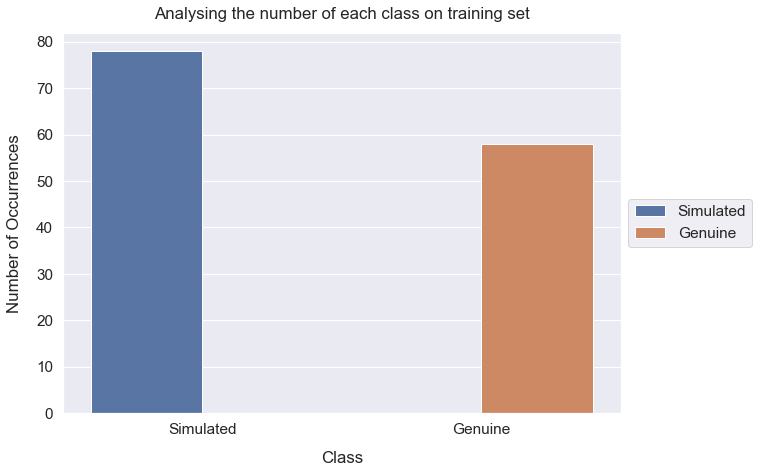

In [9]:
# Visualizando a distribuição dos dados de treino
PlotCategorical(train, 
                x="classification", 
                title="Analysing the number of each class on training set",
                x_label="Class",
                y_label="Number of Occurrences")

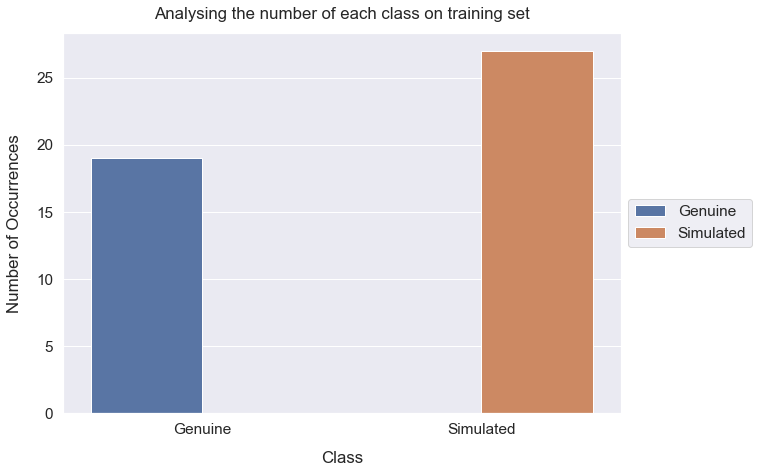

In [10]:
# Visualizando a distribuição dos dados de teste
PlotCategorical(test, 
                x="classification", 
                title="Analysing the number of each class on training set",
                x_label="Class",
                y_label="Number of Occurrences")

In [11]:
# Com o intuito de ter uma melhor generalização da nossa rede, faremos um data augmentation
# Visto que tambem temos uma pouca quantidade de dados, essa alternativa se torna promissora

# Nas configurações de treinamento definimos as seguintes configurações
## As imagens terão um giro horizontal
## As imagens terão um giro vertical
## O grau de rotação é de 90
## Um zoom de 20% feito de forma randomica
## Uma normalização da imagem que está num range de 0 - 255, para um range entre 0 - 1

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90,
                             zoom_range=0.2,
                             rescale=1./255)

## O tamanho da imagens, tanto de treino quanto de teste, está definido em 299 de largura e 299 de altura, com 3 canais de cores
train_gen = datagen.flow_from_dataframe(train, x_col="path", 
                                        y_col="classification",
                                        class_mode='binary',
                                        target_size=(299, 299), 
                                        color_mode='rgb')

# Para os dados de teste, evitaremos tantas alterações, pois se o tivermos, haverá perda de informação
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             rescale=1./255)

test_gen = datagen.flow_from_dataframe(test, x_col="path", 
                                       y_col="classification",
                                       class_mode='binary',
                                       target_size=(299, 299), 
                                       color_mode='rgb',
                                       shuffle=False)

Found 135 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


In [12]:
train_gen.class_indices

{'Genuine': 0, 'Simulated': 1}

In [13]:
# Para o modelo de convolução, utilizaremos a VGG16, devido sua simplicidade e efetividade
# O modelo está treinado com o dataset imagenet
# Utilizaremos assim para que possamos realizar uma transferencia de aprendizado, ou seja
# Utilizaremos pesos previos com o intuito de melhorar a acertividade
# O motivo de utilizar a transferencia de aprendizado se dá devido a pouca quantidade de dados a serem treinados

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# A arquitetura fora elaborada no artigo abaixo
# https://arxiv.org/abs/1409.1556

In [14]:
# Para realizar a transferencia de aprendizado, primeiramente congelamos todas as camadas da VGG16
# Ou seja, tornamos seus paramentros não treináveis

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [15]:
# Aqui será criado o modelo com a VGG na base da rede
# E no topo está os perceptrons multicamada (MLP) para a classificação
# As camadas adicionadas não serão congeladas

model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D(name='gap'))
model.add(Dense(4096, activation='relu', name='fc_1'))
model.add(Dropout(0.3, name='dropout_1'))
model.add(Dense(256, activation='relu', name='fc_2'))
model.add(Dropout(0.1, name='dropout_2'))


# Neste exemplo, será feito uma classificação binária entre as assinaturas originais e as falsificadas
model.add(Dense(1, activation='sigmoid', name='output'))

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc_2 (Dense)                 (None, 256)               1048832   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________________________

In [16]:
# Ao compilarmos o modelo será utilizado:
## Root Mean Square Propagation como otimizador da rede
## A medida de perda está definidada com binary_crossentropy
## As metricas definidas são: Acurácia, Erro Médio Absoluto e o Quadrado Médio dos Erros

model.compile(optimizer=RMSprop(1e-4), 
              loss=binary_crossentropy, 
              metrics=['acc', 'mse', 'mae'])

# O otimizador fora elaborado no artigo abaixo
# https://arxiv.org/abs/1807.06766



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# Este primeiro treinamento visa retirar os pesos aleatórios da MLP
# Assim ela receberá a propagação os pesos do treinamento da imagenet na base de dados deste desafio

# Sendo assim, teremos apenas 1 epoca
# 200 passos para a epoca
# 32 passos para a validação dos dados de treinamento
# Os 8 núcleos de processamento serão utilizados

model.fit_generator(train_gen, 
                    steps_per_epoch=200, 
                    validation_data=test_gen, 
                    validation_steps=32, 
                    epochs=1, 
                    workers=8)



Epoch 1/1
200/200 [==============================] - 171s 856ms/step - loss: 0.4811 - acc: 0.7768 - mean_squared_error: 0.1573 - mean_absolute_error: 0.3536 - val_loss: 0.2868 - val_acc: 0.9778 - val_mean_squared_error: 0.0743 - val_mean_absolute_error: 0.2354


In [18]:
# Descongelando o bloco 5 da VGG16, assim será possuí extrair as características de mais alto nivel do dataset

for i, layer in enumerate(base_model.layers):
    if i < 15:
        layer.trainable = False
        print(f"Layer name: {layer.name} \nPosition layer: {i} \nTrainable: {layer.trainable}\n")
    else:
        layer.trainable = True
        print(f"Layer name: {layer.name} \nPosition layer: {i} \nTrainable: {layer.trainable}\n")

Layer name: input_1 
Position layer: 0 
Trainable: False

Layer name: block1_conv1 
Position layer: 1 
Trainable: False

Layer name: block1_conv2 
Position layer: 2 
Trainable: False

Layer name: block1_pool 
Position layer: 3 
Trainable: False

Layer name: block2_conv1 
Position layer: 4 
Trainable: False

Layer name: block2_conv2 
Position layer: 5 
Trainable: False

Layer name: block2_pool 
Position layer: 6 
Trainable: False

Layer name: block3_conv1 
Position layer: 7 
Trainable: False

Layer name: block3_conv2 
Position layer: 8 
Trainable: False

Layer name: block3_conv3 
Position layer: 9 
Trainable: False

Layer name: block3_pool 
Position layer: 10 
Trainable: False

Layer name: block4_conv1 
Position layer: 11 
Trainable: False

Layer name: block4_conv2 
Position layer: 12 
Trainable: False

Layer name: block4_conv3 
Position layer: 13 
Trainable: False

Layer name: block4_pool 
Position layer: 14 
Trainable: False

Layer name: block5_conv1 
Position layer: 15 
Trainable: Tr

In [19]:
# Será feita outra compilação pois a camada de características de alto nível da VGG fora descongelada
# A diferença entre esta e a anterior é que nesta utilizaremos o otimizador Adam

model.compile(optimizer=Adam(lr=1e-6), 
              loss=binary_crossentropy, 
              metrics=['acc', 'mse', 'mae'])

# O otimizador fora elaborado no artigo abaixo
# https://arxiv.org/abs/1412.6980

In [20]:
checkpoint = ModelCheckpoint('best_genuine_simulated.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')



callbacks_list = [checkpoint]

In [21]:
# Aqui se tem de fato o treino de nossa base de dados
# Nela está definido todos os paramentros do treinamento anterior
# A diferença se encontra na quantidade de epocas, aqui definida como 20

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=200, 
                              validation_data=test_gen, 
                              validation_steps=32,
                              callbacks=callbacks_list,
                              epochs=20, 
                              workers=8)

Epoch 1/20
200/200 [==============================] - 170s 850ms/step - loss: 0.2395 - acc: 0.9258 - mean_squared_error: 0.0657 - mean_absolute_error: 0.1870 - val_loss: 0.2036 - val_acc: 0.9778 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1644

Epoch 00001: val_loss improved from inf to 0.20364, saving model to best_genuine_simulated.h5
Epoch 2/20
200/200 [==============================] - 157s 784ms/step - loss: 0.1818 - acc: 0.9405 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1398 - val_loss: 0.1584 - val_acc: 0.9778 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1269

Epoch 00002: val_loss improved from 0.20364 to 0.15842, saving model to best_genuine_simulated.h5
Epoch 3/20
200/200 [==============================] - 157s 786ms/step - loss: 0.1322 - acc: 0.9616 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1036 - val_loss: 0.1330 - val_acc: 0.9778 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1057

Epoch 00003: val_lo

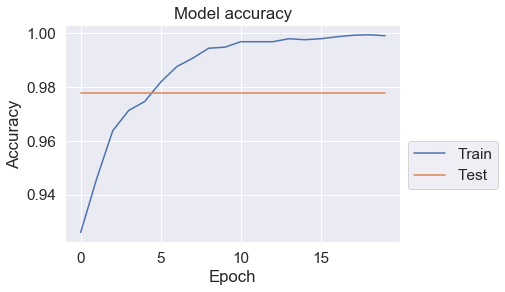

In [22]:
PlotHistoryAccuracy(history)

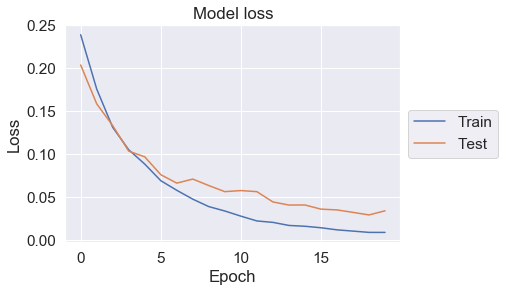

In [23]:
PlotHistoryLoss(history)

## Análise dos Resultados: Genuine | Simulated

In [24]:
# Nesta seção utilizaremos dois métodos para visualizar "dentro" da rede treinada

# O T-SNE e o PCA visam diminuir a dimensionalidade das caracteristicas
# Aqui elas serão utilizadas para observar como os dados estão se alocando
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Artigos T-SNE e PCA
## http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf -> TSNE
## https://www.researchgate.net/publication/316652806_Principal_Component_Analysis -> PCA

In [25]:
# Nesta célula, criaremos o extrator de caracteristicas
# Nele será capturado os dados que passam na camada fc_1 
# definida na célula onde fora criado o modelo classificatório

feature_extractor = Model(inputs=model.input,
                          outputs=model.get_layer('fc_2').output)

In [26]:
# É realizado uma inferencia nos dados de teste para que se possa capturar as suas caracteristicas
features = feature_extractor.predict_generator(test_gen, steps=len(test_gen))

[t-SNE] Computing 44 nearest neighbors...
[t-SNE] Indexed 45 samples in 0.001s...
[t-SNE] Computed neighbors for 45 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 45 / 45
[t-SNE] Mean sigma: 8.355063
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.030853
[t-SNE] KL divergence after 1000 iterations: 0.396109


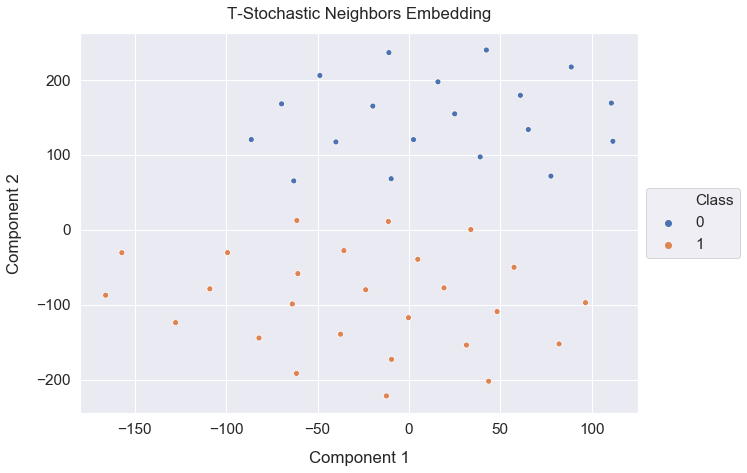

In [27]:
PlotTSNE(features, test_gen)

### Observando a imagem acima, se percebe que há uma divisão entre os dados gerada pelo T-SNE

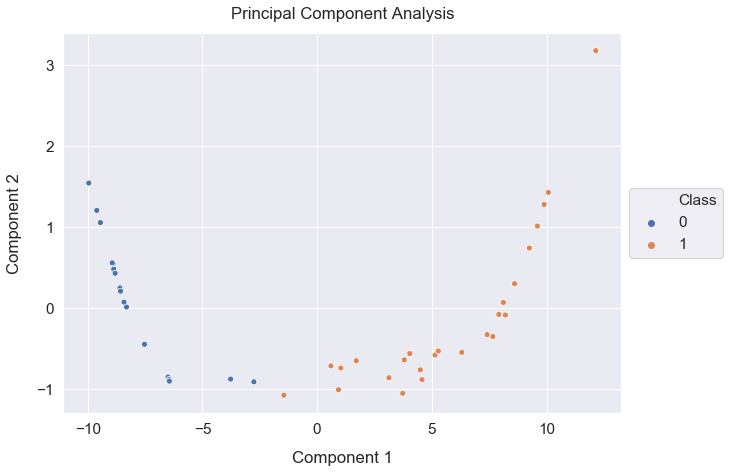

In [28]:
PlotPCA(features, test_gen)

### E também na imagem acima percebe-se que o PCA fora capaz de observar essa divisão

### Isso demonstra que o modelo está sendo efetivo!

### Além de possuir uma acurácia válida de 97.78%

In [29]:
# Salvando o modelo

model.save('model_genuine_or_simulated_fraud_detection.h5')

In [30]:
# Somente o "Reference" não serão utilizados para treinamento

train_df = df[df.classification != 'Reference']

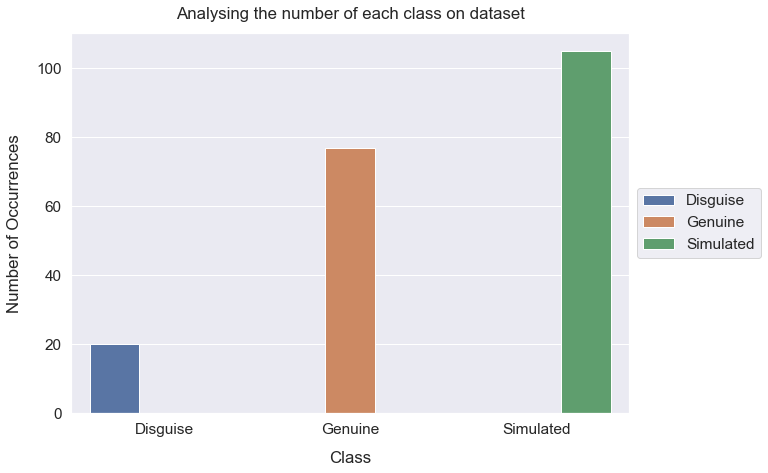

In [31]:
PlotCategorical(train_df, 
                x="classification", 
                title="Analysing the number of each class on dataset",
                x_label="Class",
                y_label="Number of Occurrences")

In [32]:
train, test = train_test_split(train_df, 
                               test_size=0.25,
                               random_state=42,
                               stratify=train_df["classification"])

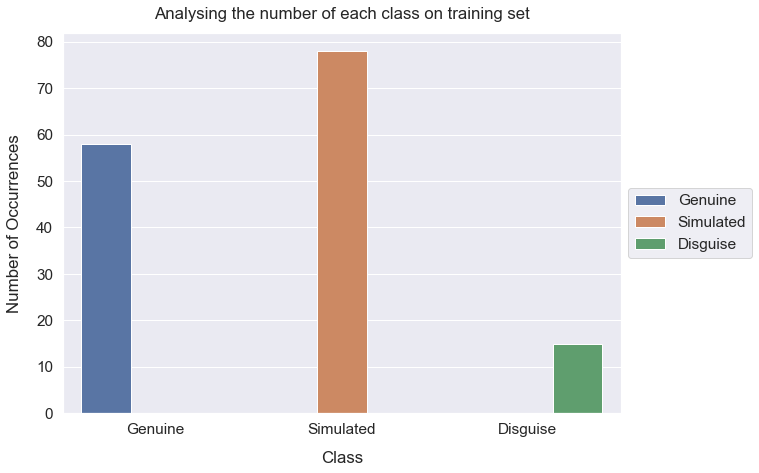

In [33]:
PlotCategorical(train, 
                x="classification", 
                title="Analysing the number of each class on training set",
                x_label="Class",
                y_label="Number of Occurrences")

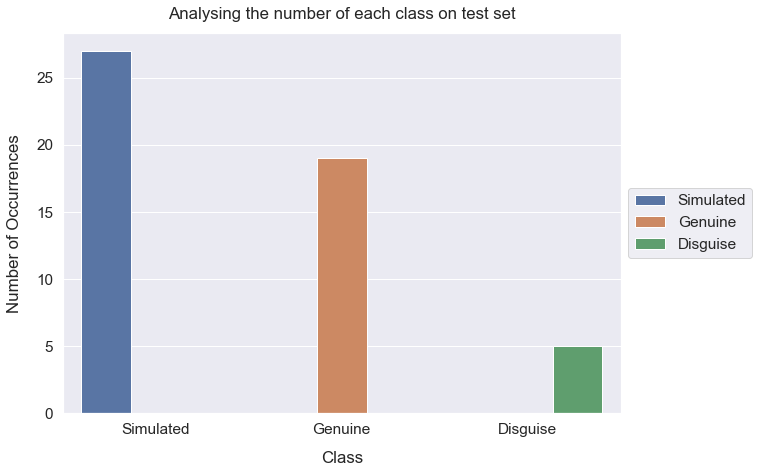

In [34]:
PlotCategorical(test, 
                x="classification", 
                title="Analysing the number of each class on test set",
                x_label="Class",
                y_label="Number of Occurrences")

In [35]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

In [36]:
for layer in base_model.layers:
    layer.trainable = False

In [37]:
model = []

# Aqui será criado o modelo com a VGG na base da rede
# E no topo está os perceptrons multicamada (MLP) para a classificação
# As camadas adicionadas não serão congeladas

model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D(name='gap'))
model.add(Dense(4096, activation='relu', name='fc_1'))
model.add(Dropout(0.3, name='dropout_1'))
model.add(Dense(256, activation='relu', name='fc_2'))
model.add(Dropout(0.1, name='dropout_2'))

# Neste exemplo, será feito uma classificação categorica entre as assinaturas originais, falsificadas e as tentativas de modificação do autor das assinaturas originais
model.add(Dense(3, activation='softmax', name='output'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 512)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              2101248   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc_2 (Dense)                 (None, 256)               1048832   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 771       
Total para

In [38]:
## Diferente do modelo anterior, neste teremos uma classificação categorica, ou seja, de duas os mais classes

# Com o intuito de ter uma melhor generalização da nossa rede, faremos um data augmentation
# Visto que tambem temos uma pouca quantidade de dados, essa alternativa se torna promissora

# Nas configurações de treinamento definimos as seguintes configurações
## As imagens terão um giro horizontal
## As imagens terão um giro vertical
## O grau de rotação é de 90
## Um zoom de 20% feito de forma randomica
## Uma normalização da imagem que está num range de 0 - 255, para um range entre 0 - 1

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90,
                             zoom_range=0.2,
                             rescale=1./255)

## O tamanho da imagens, tanto de treino quanto de teste, está definido em 299 de largura e 299 de altura, com 3 canais de cores
train_gen = datagen.flow_from_dataframe(train, x_col="path", 
                                        y_col="classification",
                                        class_mode='categorical',
                                        target_size=(299, 299), 
                                        color_mode='rgb')

# Para os dados de teste, evitaremos tantas alterações, pois se o tivermos, haverá perda de informação
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             rescale=1./255)

test_gen = datagen.flow_from_dataframe(test, x_col="path", 
                                       y_col="classification",
                                       class_mode='categorical',
                                       target_size=(299, 299), 
                                       color_mode='rgb',
                                       shuffle=False)

Found 150 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [39]:
# Ao compilarmos o modelo será utilizado:
## Root Mean Square Propagation como otimizador da rede
## A medida de perda está definidada com binary_crossentropy
## As metricas definidas são: Acurácia, Erro Médio Absoluto e o Quadrado Médio dos Erros

model.compile(optimizer=RMSprop(1e-4), 
              loss=categorical_crossentropy, 
              metrics=['acc', 'mse', 'mae'])

# O otimizador fora elaborado no artigo abaixo
# https://arxiv.org/abs/1807.06766

In [40]:
# Este primeiro treinamento visa retirar os pesos aleatórios da MLP
# Assim ela receberá a propagação os pesos do treinamento da imagenet na base de dados deste desafio

# Sendo assim, teremos apenas 1 epoca
# 200 passos para a epoca
# 32 passos para a validação dos dados de treinamento
# Os 8 núcleos de processamento serão utilizados

model.fit_generator(train_gen, 
                    steps_per_epoch=200, 
                    validation_data=test_gen, 
                    validation_steps=32, 
                    epochs=1, 
                    workers=8)

Epoch 1/1
200/200 [==============================] - 179s 894ms/step - loss: 0.6696 - acc: 0.7037 - mean_squared_error: 0.1332 - mean_absolute_error: 0.2922 - val_loss: 0.5386 - val_acc: 0.8000 - val_mean_squared_error: 0.0993 - val_mean_absolute_error: 0.2126


In [41]:
# Descongelando o bloco 5 da VGG16, assim conseguiremos extrair as características de mais alto nivel

for i, layer in enumerate(base_model.layers):
    if i < 15:
        layer.trainable = False
        print(f"Layer name: {layer.name} \nPosition layer: {i} \nTrainable: {layer.trainable}\n")
    else:
        layer.trainable = True
        print(f"Layer name: {layer.name} \nPosition layer: {i} \nTrainable: {layer.trainable}\n")

Layer name: input_2 
Position layer: 0 
Trainable: False

Layer name: block1_conv1 
Position layer: 1 
Trainable: False

Layer name: block1_conv2 
Position layer: 2 
Trainable: False

Layer name: block1_pool 
Position layer: 3 
Trainable: False

Layer name: block2_conv1 
Position layer: 4 
Trainable: False

Layer name: block2_conv2 
Position layer: 5 
Trainable: False

Layer name: block2_pool 
Position layer: 6 
Trainable: False

Layer name: block3_conv1 
Position layer: 7 
Trainable: False

Layer name: block3_conv2 
Position layer: 8 
Trainable: False

Layer name: block3_conv3 
Position layer: 9 
Trainable: False

Layer name: block3_pool 
Position layer: 10 
Trainable: False

Layer name: block4_conv1 
Position layer: 11 
Trainable: False

Layer name: block4_conv2 
Position layer: 12 
Trainable: False

Layer name: block4_conv3 
Position layer: 13 
Trainable: False

Layer name: block4_pool 
Position layer: 14 
Trainable: False

Layer name: block5_conv1 
Position layer: 15 
Trainable: Tr

In [42]:
# Será feita outra compilação pois a camada de características de alto nível da VGG fora descongelada
# A diferença entre esta e a anterior é que nesta utilizaremos o otimizador Adam

model.compile(optimizer=Adam(lr=1e-6), 
              loss=categorical_crossentropy, 
              metrics=['acc', 'mse', 'mae'])

# O otimizador fora elaborado no artigo abaixo
# https://arxiv.org/abs/1412.6980

In [43]:
checkpoint = ModelCheckpoint('best_genuine_simulated_disguise.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')



callbacks_list = [checkpoint]

In [44]:
# Aqui se tem de fato o treino de nossa base de dados
# Nela está definido todos os paramentros do treinamento anterior
# A diferença se encontra na quantidade de epocas, aqui definida como 20


history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=200, 
                              validation_data=test_gen, 
                              validation_steps=32,
                              callbacks=callbacks_list,
                              epochs=20, 
                              workers=8)

Epoch 1/20
200/200 [==============================] - 180s 902ms/step - loss: 0.3612 - acc: 0.8868 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1747 - val_loss: 0.3516 - val_acc: 0.8800 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.1496

Epoch 00001: val_loss improved from inf to 0.35164, saving model to best_genuine_simulated_disguise.h5
Epoch 2/20
200/200 [==============================] - 173s 863ms/step - loss: 0.2602 - acc: 0.9217 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1297 - val_loss: 0.2984 - val_acc: 0.9000 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.1193

Epoch 00002: val_loss improved from 0.35164 to 0.29840, saving model to best_genuine_simulated_disguise.h5
Epoch 3/20
200/200 [==============================] - 168s 841ms/step - loss: 0.2067 - acc: 0.9402 - mean_squared_error: 0.0342 - mean_absolute_error: 0.1028 - val_loss: 0.2706 - val_acc: 0.9000 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1018

E

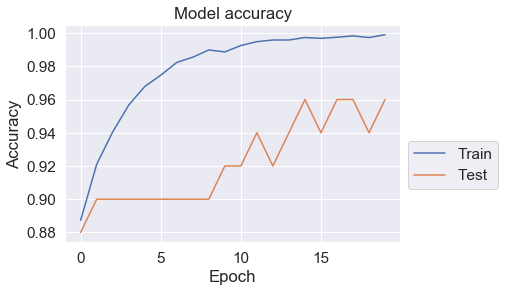

In [45]:
PlotHistoryAccuracy(history)

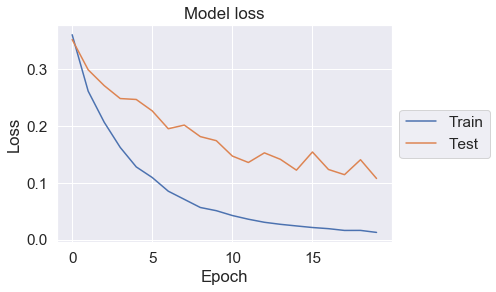

In [46]:
PlotHistoryLoss(history)

## Analise dos resultados: Genuine | Simulated | Disguised

In [47]:
# Nesta célula, criaremos o extrator de caracteristicas
# Nele será capturado os dados que passam na camada fc_1 
# definida na célula onde fora criado o modelo classificatório

feature_extractor = Model(inputs=model.input,
                          outputs=model.get_layer('fc_1').output)

In [48]:
# É realizado uma inferencia nos dados de teste para que se possa capturar as suas caracteristicas
features = feature_extractor.predict_generator(test_gen, steps=len(test_gen))

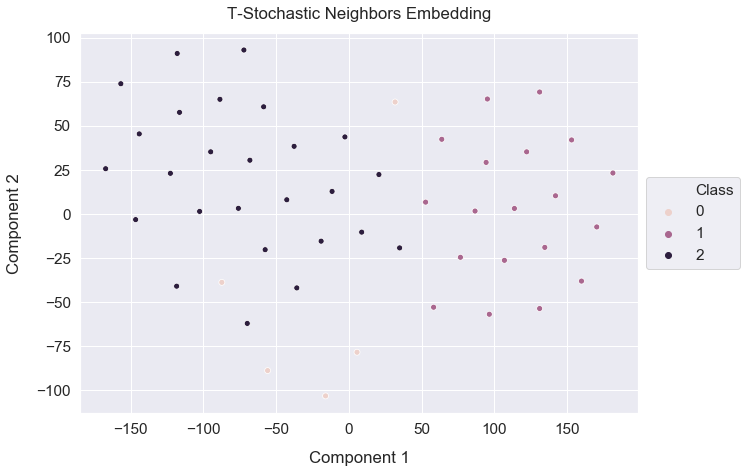

In [53]:
# Platando a distribuição dos dados gerados pelo TSNE no eixo X e Y

PlotTSNE(features, test_gen)

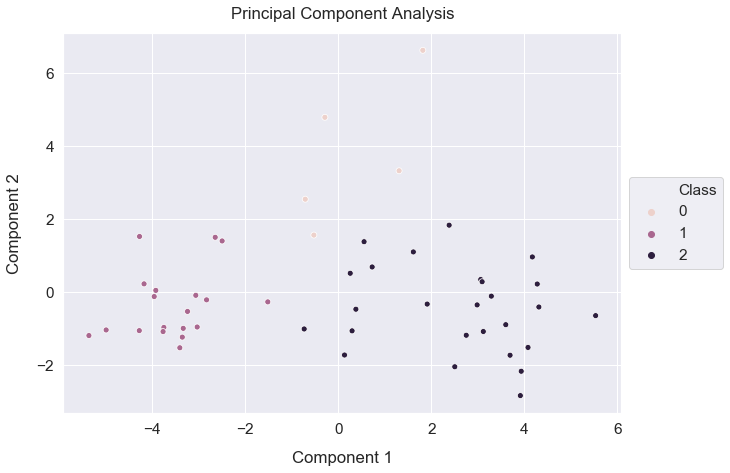

In [54]:
# Platando a distribuição dos dados gerados pelo TSNE no eixo X e Y

PlotPCA(features, test_gen)

In [55]:
model.save('model_genuine_simulated_disguise_fraud_detection.h5')